In [1]:
%matplotlib inline

import os
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

from sqlalchemy import create_engine
import pymongo
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# ga_data=pd.read_csv("train.csv")
# ga_data

In [3]:
#def load_df(csv_path='train.csv', nrows=None):
json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']

ga_data = pd.read_csv('../GACustomerRevenue/train.csv', 
                 converters={column: json.loads for column in json_columns}, 
                 dtype={'fullVisitorId': 'str'},
                     )
                 #nrows=100)
ga_data.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",1131660440785968503,"{'continent': 'Asia', 'subContinent': 'Western...",1131660440785968503_1472830385,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472830385,1,1472830385
1,Organic Search,20160902,"{'browser': 'Firefox', 'browserVersion': 'not ...",377306020877927890,"{'continent': 'Oceania', 'subContinent': 'Aust...",377306020877927890_1472880147,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472880147,1,1472880147
2,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",3895546263509774583,"{'continent': 'Europe', 'subContinent': 'South...",3895546263509774583_1472865386,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472865386,1,1472865386
3,Organic Search,20160902,"{'browser': 'UC Browser', 'browserVersion': 'n...",4763447161404445595,"{'continent': 'Asia', 'subContinent': 'Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472881213,1,1472881213
4,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",27294437909732085,"{'continent': 'Europe', 'subContinent': 'North...",27294437909732085_1472822600,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472822600,2,1472822600


In [4]:
for column in json_columns:
    column_as_df = pd.json_normalize(ga_data[column])
    column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
    ga_data = ga_data.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
ga_data

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,Social,20170104,5123779100307500332,5123779100307500332_1483554750,Not Socially Engaged,1483554750,1,1483554750,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,/yt/about/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903649,Social,20170104,7231728964973959842,7231728964973959842_1483543798,Not Socially Engaged,1483543798,1,1483543798,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,/yt/about/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903650,Social,20170104,5744576632396406899,5744576632396406899_1483526434,Not Socially Engaged,1483526434,1,1483526434,Android Webview,not available in demo dataset,...,not available in demo dataset,NaN,/yt/about/ko/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903651,Social,20170104,2709355455991750775,2709355455991750775_1483592857,Not Socially Engaged,1483592857,1,1483592864,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,/l.php,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
ga_data.shape

(903653, 55)

In [6]:
ga_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

In [7]:
print("Channel Grouping:", ga_data.channelGrouping.unique().tolist())
print("Social Engagement Type:", ga_data.socialEngagementType.unique().tolist())
print("Number of unique IDs:",len(ga_data.visitId.unique()))
print("Browser used:", ga_data["device.browser"].unique())

Channel Grouping: ['Organic Search', 'Referral', 'Paid Search', 'Affiliates', 'Direct', 'Display', 'Social', '(Other)']
Social Engagement Type: ['Not Socially Engaged']
Number of unique IDs: 886303
Browser used: ['Chrome' 'Firefox' 'UC Browser' 'Internet Explorer' 'Safari' 'Edge'
 'Opera Mini' 'Opera' 'BlackBerry' 'Safari (in-app)' 'Coc Coc'
 'Mozilla Compatible Agent' 'ADM' 'MRCHROME' 'Amazon Silk' 'YaBrowser'
 'Android Webview' 'Puffin' 'Nokia Browser' 'Maxthon' 'Nintendo Browser'
 'Android Browser' 'Lunascape' 'IE with Chrome Frame' 'ThumbSniper'
 'LYF_LS_4002_12' 'Mozilla' 'osee2unifiedRelease' 'NokiaE52-1' 'Iron'
 '[Use default User-agent string] LIVRENPOCHE' '(not set)'
 'LYF_LS_4002_11' 'M5' 'Android Runtime' 'Apple-iPhone7C2' 'SeaMonkey'
 'Konqueror' 'Seznam' 'Changa 99695759' 'no-ua' 'MQQBrowser' 'Nichrome'
 'HTC802t_TD' 'DASH_JR_3G' 'DoCoMo' 'subjectAgent: NoticiasBoom' 'YE'
 'User Agent' '0' 'Hisense M20-M_LTE' 'Reddit' 'TCL P500M' 'CSM Click']


In [8]:
print("Browser used:", ga_data["geoNetwork.country"].unique())

Browser used: ['Turkey' 'Australia' 'Spain' 'Indonesia' 'United Kingdom' 'Italy'
 'Pakistan' 'Austria' 'Netherlands' 'India' 'France' 'Brazil' 'China'
 'Singapore' 'Argentina' 'Poland' 'Germany' 'Canada' 'Thailand' 'Hungary'
 'Malaysia' 'Denmark' 'Taiwan' 'Russia' 'Nigeria' 'Belgium' 'South Korea'
 'Chile' 'Ireland' 'Philippines' 'Greece' 'Mexico' 'Montenegro'
 'United States' 'Bangladesh' 'Japan' 'Slovenia' 'Czechia' 'Sweden'
 'United Arab Emirates' 'Switzerland' 'Portugal' 'Peru' 'Hong Kong'
 'Vietnam' 'Sri Lanka' 'Serbia' 'Norway' 'Romania' 'Kenya' 'Ukraine'
 'Israel' 'Slovakia' '(not set)' 'Lithuania' 'Puerto Rico'
 'Bosnia & Herzegovina' 'Croatia' 'South Africa' 'Paraguay' 'Botswana'
 'Colombia' 'Uruguay' 'Algeria' 'Finland' 'Guatemala' 'Egypt' 'Malta'
 'Bulgaria' 'New Zealand' 'Kuwait' 'Uzbekistan' 'Saudi Arabia' 'Cyprus'
 'Estonia' 'Côte d’Ivoire' 'Morocco' 'Tunisia' 'Venezuela'
 'Dominican Republic' 'Senegal' 'Cape Verde' 'Costa Rica' 'Kazakhstan'
 'Macedonia (FYROM)' 'Oman' 'L

## Percentage of NAN values in each column

In [9]:
ga_data.isna().sum()/len(ga_data) * 100

channelGrouping                                       0.000000
date                                                  0.000000
fullVisitorId                                         0.000000
sessionId                                             0.000000
socialEngagementType                                  0.000000
visitId                                               0.000000
visitNumber                                           0.000000
visitStartTime                                        0.000000
device.browser                                        0.000000
device.browserVersion                                 0.000000
device.browserSize                                    0.000000
device.operatingSystem                                0.000000
device.operatingSystemVersion                         0.000000
device.isMobile                                       0.000000
device.mobileDeviceBranding                           0.000000
device.mobileDeviceModel                              0

In [10]:
unique_value_cols = []
columns = ga_data.columns
for column in columns:
     if ga_data[column].nunique() == 1: unique_value_cols.append(column)
print('Number of columns with constant values:',len(unique_value_cols))
unique_value_cols

Number of columns with constant values: 24


['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode']

In [11]:
ga_data[['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode']]

,socialEngagementType,device.browserVersion,device.browserSize,device.operatingSystemVersion,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,...,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.bounces,totals.newVisits,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,not available in demo dataset,NaN,NaN,NaN
1,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,not available in demo dataset,NaN,NaN,NaN
2,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,not available in demo dataset,NaN,NaN,NaN
3,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,not available in demo dataset,NaN,NaN,NaN
4,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,NaN,not available in demo dataset,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,NaN,1,not available in demo dataset,NaN,NaN,NaN
903649,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,NaN,1,not available in demo dataset,NaN,NaN,NaN
903650,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not a

Remove columns with high NAN value percentage and unique data in all columns which is not relevent.

In [12]:
ga_data_clean = ga_data.drop(columns=
                             ['socialEngagementType','device.browserVersion','device.browserSize','device.operatingSystemVersion',
                              'device.mobileDeviceBranding','device.mobileDeviceModel','device.mobileInputSelector',
                              'device.mobileDeviceInfo','device.mobileDeviceMarketingName','device.flashVersion',
                              'device.language','device.screenColors','device.screenResolution',
                              'geoNetwork.cityId','geoNetwork.latitude','geoNetwork.longitude',
                              'geoNetwork.networkLocation','trafficSource.adwordsClickInfo.criteriaParameters','trafficSource.isTrueDirect',
                              'trafficSource.referralPath','trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.slot',
                              'trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.isVideoAd',
                              'trafficSource.adContent','trafficSource.campaignCode'
                             ])

In [13]:
ga_data_clean

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,...,1,1,1,1,1,NaN,(not set),google,organic,(not provided)
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,...,1,1,1,1,1,NaN,(not set),google,organic,(not provided)
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,Windows,False,...,1,1,1,1,1,NaN,(not set),google,organic,(not provided)
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,Linux,False,...,1,1,1,1,1,NaN,(not set),google,organic,google + online
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,Android,True,...,1,1,1,1,NaN,NaN,(not set),google,organic,(not provided)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,Social,20170104,5123779100307500332,5123779100307500332_1483554750,1483554750,1,1483554750,Chrome,Windows,False,...,1,17,15,NaN,1,NaN,(not set),youtube.com,referral,NaN
903649,Social,20170104,7231728964973959842,7231728964973959842_1483543798,1483543798,1,1483543798,Chrome,Android,True,...,1,18,13,NaN,1,NaN,(not set),youtube.com,referral,NaN
903650,Social,20170104,5744576632396406899,5744576632396406899_1483526434,1483526434,1,1483526434,Android Webview,Android,True,...,1,24,21,NaN,1,NaN,(not set),youtube.com,referral,NaN
903651,Social,20170104,2709355455991750775,2709355455991750775_1483592857,1483592857,1,1483592864,Chrome,Windows,False,...,1,24,22,NaN,1,NaN,(not set),facebook.com,referral,NaN


In [14]:
ga_data_clean.shape

(903653, 28)

In [15]:
ga_data_clean.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.visits', 'totals.hits',
       'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium',
       'trafficSource.keyword'],
      dtype='object')

In [16]:
ga_data_clean.drop(columns=['sessionId', 'visitId'], inplace=True)
ga_data_clean

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,...,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword
0,Organic Search,20160902,1131660440785968503,1,1472830385,Chrome,Windows,False,desktop,Asia,...,1,1,1,1,1,NaN,(not set),google,organic,(not provided)
1,Organic Search,20160902,377306020877927890,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,...,1,1,1,1,1,NaN,(not set),google,organic,(not provided)
2,Organic Search,20160902,3895546263509774583,1,1472865386,Chrome,Windows,False,desktop,Europe,...,1,1,1,1,1,NaN,(not set),google,organic,(not provided)
3,Organic Search,20160902,4763447161404445595,1,1472881213,UC Browser,Linux,False,desktop,Asia,...,1,1,1,1,1,NaN,(not set),google,organic,google + online
4,Organic Search,20160902,27294437909732085,2,1472822600,Chrome,Android,True,mobile,Europe,...,1,1,1,1,NaN,NaN,(not set),google,organic,(not provided)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,Social,20170104,5123779100307500332,1,1483554750,Chrome,Windows,False,desktop,Americas,...,1,17,15,NaN,1,NaN,(not set),youtube.com,referral,NaN
903649,Social,20170104,7231728964973959842,1,1483543798,Chrome,Android,True,mobile,Asia,...,1,18,13,NaN,1,NaN,(not set),youtube.com,referral,NaN
903650,Social,20170104,5744576632396406899,1,1483526434,Android Webview,Android,True,mobile,Asia,...,1,24,21,NaN,1,NaN,(not set),youtube.com,referral,NaN
903651,Social,20170104,2709355455991750775,1,1483592864,Chrome,Windows,False,desktop,Asia,...,1,24,22,NaN,1,NaN,(not set),facebook.com,referral,NaN


In [17]:
pd.options.display.max_columns=ga_data_clean.shape[1]
ga_data_clean

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword
0,Organic Search,20160902,1131660440785968503,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1,1,1,1,NaN,(not set),google,organic,(not provided)
1,Organic Search,20160902,377306020877927890,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1,1,1,1,NaN,(not set),google,organic,(not provided)
2,Organic Search,20160902,3895546263509774583,1,1472865386,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1,1,1,1,1,NaN,(not set),google,organic,(not provided)
3,Organic Search,20160902,4763447161404445595,1,1472881213,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,1,1,1,NaN,(not set),google,organic,google + online
4,Organic Search,20160902,27294437909732085,2,1472822600,Chrome,Android,True,mobile,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,1,1,NaN,NaN,(not set),google,organic,(not provided)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,Social,20170104,5123779100307500332,1,1483554750,Chrome,Windows,False,desktop,Americas,Caribbean,Puerto Rico,not available in demo dataset,not available in demo dataset,not available in demo dataset,prtc.net,1,17,15,NaN,1,NaN,(not set),youtube.com,referral,NaN
903649,Social,20170104,7231728964973959842,1,1483543798,Chrome,Android,True,mobile,Asia,Southern Asia,Sri Lanka,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,18,13,NaN,1,NaN,(not set),youtube.com,referral,NaN
903650,Social,20170104,5744576632396406899,1,1483526434,Android Webview,Android,True,mobile,Asia,Eastern Asia,South Korea,Seoul,(not set),Seoul,unknown.unknown,1,24,21,NaN,1,NaN,(not set),youtube.com,referral,NaN
903651,Social,20170104,2709355455991750775,1,1483592864,Chrome,Windows,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,24,22,NaN,1,NaN,(not set),facebook.com,referral,NaN


In [38]:
ga_data_clean.fillna(0, inplace=True)
ga_data_clean['totals.transactionRevenue'] = ga_data_clean['totals.transactionRevenue'].astype('float')
ga_data_clean['totals.visits'] = ga_data_clean['totals.visits'].astype('int32')
ga_data_clean

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword
0,Organic Search,20160902,1131660440785968503,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1,1,1,1,0.0,(not set),google,organic,(not provided)
1,Organic Search,20160902,377306020877927890,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1,1,1,1,0.0,(not set),google,organic,(not provided)
2,Organic Search,20160902,3895546263509774583,1,1472865386,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1,1,1,1,1,0.0,(not set),google,organic,(not provided)
3,Organic Search,20160902,4763447161404445595,1,1472881213,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,1,1,1,0.0,(not set),google,organic,google + online
4,Organic Search,20160902,27294437909732085,2,1472822600,Chrome,Android,True,mobile,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,1,1,0,0.0,(not set),google,organic,(not provided)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,Social,20170104,5123779100307500332,1,1483554750,Chrome,Windows,False,desktop,Americas,Caribbean,Puerto Rico,not available in demo dataset,not available in demo dataset,not available in demo dataset,prtc.net,1,17,15,0,1,0.0,(not set),youtube.com,referral,0
903649,Social,20170104,7231728964973959842,1,1483543798,Chrome,Android,True,mobile,Asia,Southern Asia,Sri Lanka,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,18,13,0,1,0.0,(not set),youtube.com,referral,0
903650,Social,20170104,5744576632396406899,1,1483526434,Android Webview,Android,True,mobile,Asia,Eastern Asia,South Korea,Seoul,(not set),Seoul,unknown.unknown,1,24,21,0,1,0.0,(not set),youtube.com,referral,0
903651,Social,20170104,2709355455991750775,1,1483592864,Chrome,Windows,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,24,22,0,1,0.0,(not set),facebook.com,referral,0


In [40]:
traffic_source_totals_df = ga_data_clean.groupby(by=['trafficSource.source'])['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'trafficSource.source':'traffic_source','count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})\
                         .sort_values(by=['mean_revenue'], ascending=False)
traffic_source_totals_df

,traffic_source,no_of_users,total_revenue,mean_revenue
79,basecamp.com,2,1.058000e+08,5.290000e+07
262,mail.aol.com,3,5.685000e+07,1.895000e+07
263,mail.google.com,1457,2.332791e+10,1.601092e+07
120,dfa,5686,7.692842e+10,1.352944e+07
325,search.myway.com,8,1.009400e+08,1.261750e+07
...,...,...,...,...
130,evernote.com,3,0.000000e+00,0.000000e+00
129,espanol.search.yahoo.com,1,0.000000e+00,0.000000e+00
128,es.search.yahoo.com,4,0.000000e+00,0.000000e+00
127,en.wikipedia.org,6,0.000000e+00,0.000000e+00


In [67]:
traffic_campaign_totals_df = ga_data_clean.groupby(by=['trafficSource.campaign'])['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'trafficSource.campaign':'traffic_source','count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})\
                         .sort_values(by=['mean_revenue'], ascending=False)
traffic_campaign_totals_df

,traffic_source,no_of_users,total_revenue,mean_revenue
1,AW - Accessories,7070,1.541782e+10,2.180738e+06
3,AW - Dynamic Search Ads Whole Site,14244,2.713255e+10,1.904841e+06
0,(not set),865347,1.496781e+12,1.729688e+06
2,AW - Apparel,46,7.782000e+07,1.691739e+06
8,Retail (DO NOT EDIT owners nophakun and tianyu),50,2.295000e+07,4.590000e+05
9,test-liyuhz,392,4.200000e+07,1.071429e+05
7,Data Share Promo,16403,5.973800e+08,3.641895e+04
4,AW - Electronics,96,0.000000e+00,0.000000e+00
5,All Products,4,0.000000e+00,0.000000e+00
6,Data Share,1,0.000000e+00,0.000000e+00


In [39]:
continent_totals_df = ga_data_clean.groupby(by=['geoNetwork.continent'])['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'geoNetwork.continent':'continent','count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})\
                         .sort_values(by=['mean_revenue'], ascending=False)
#continent_totals_df.drop(continent_totals_df.loc[continent_totals_df['continent']=='(not set)'].index, inplace=True)
continent_totals_df

,continent,no_of_users,total_revenue,mean_revenue
2,Americas,450377,1.504672e+12,3.340916e+06
1,Africa,14745,8.687760e+09,5.892004e+05
0,(not set),1468,7.697800e+08,5.243733e+05
5,Oceania,15054,1.793230e+09,1.191198e+05
3,Asia,223698,1.740184e+10,7.779167e+04
4,Europe,198311,6.747030e+09,3.402247e+04


In [20]:
subcontinent_totals_df = ga_data_clean.groupby(by=['geoNetwork.subContinent'])['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'geoNetwork.subContinent':'subcontinent','count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})\
                         .sort_values(by=['mean_revenue'], ascending=False)
subcontinent_totals_df

,subcontinent,no_of_users,total_revenue,mean_revenue
12,Northern America,390657,1.485265e+12,3.801967e+06
5,Eastern Africa,1927,5.268700e+09,2.734146e+06
20,Western Africa,2573,3.302400e+09,1.283482e+06
2,Caribbean,2406,1.563550e+09,6.498545e+05
0,(not set),1468,7.697800e+08,5.243733e+05
15,South America,41731,1.593731e+10,3.819058e+05
6,Eastern Asia,46919,1.107522e+10,2.360498e+05
3,Central America,15583,1.905550e+09,1.222839e+05
1,Australasia,14893,1.793230e+09,1.204076e+05
16,Southeast Asia,77800,3.755990e+09,4.827751e+04


In [21]:
country_totals_df = ga_data_clean.groupby(by=['geoNetwork.country'])['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'geoNetwork.country':'country','count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})\
                         .sort_values(by=['mean_revenue'], ascending=False)
country_totals_df

,country,no_of_users,total_revenue,mean_revenue
7,Anguilla,1,1.099000e+07,1.099000e+07
51,Curaçao,30,2.063300e+08,6.877667e+06
106,Kenya,771,5.268700e+09,6.833593e+06
216,Venezuela,2132,1.337490e+10,6.273405e+06
185,St. Lucia,24,1.162100e+08,4.842083e+06
...,...,...,...,...
88,Haiti,37,0.000000e+00,0.000000e+00
89,Honduras,188,0.000000e+00,0.000000e+00
92,Iceland,142,0.000000e+00,0.000000e+00
95,Iran,41,0.000000e+00,0.000000e+00


In [22]:
visitor_totals = ga_data_clean.groupby(by=['fullVisitorId'])[['totals.visits','totals.transactionRevenue']].sum()
visitor_totals.rename(columns= {'totals.visits':'total_visits','totals.transactionRevenue':'total_revenue'}, inplace=True)
visitor_totals.sort_values(by=['total_revenue', 'total_visits'], ascending=False, inplace=True)
visitor_totals.reset_index(inplace=True)

visitor_totals

,fullVisitorId,total_visits,total_revenue
0,1957458976293878100,278,7.711343e+10
1,5632276788326171571,6,1.602375e+10
2,9417857471295131045,16,1.517012e+10
3,4471415710206918415,34,1.121110e+10
4,4984366501121503466,24,9.513900e+09
...,...,...,...
714162,9999955365228667450,1,0.000000e+00
714163,9999963186378918199,1,0.000000e+00
714164,999997225970956660,1,0.000000e+00
714165,9999978264901065827,1,0.000000e+00


In [23]:
visitor_visits_revenue = ga_data_clean.groupby(by=['fullVisitorId']).agg(
                            total_visits = ('totals.visits', sum),
                            sum_revenue = ('totals.transactionRevenue', sum))
#visitor_totals_mean.rename(columns= {'totals.visits':'total_visits','totals.transactionRevenue':'total_revenue'}, inplace=True)
visitor_visits_revenue.sort_values(by=['sum_revenue', 'total_visits'], ascending=False, inplace=True)
#visitor_totals_mean.reset_index(inplace=True)

visitor_visits_revenue

,total_visits,sum_revenue
fullVisitorId,,
1957458976293878100,278,7.711343e+10
5632276788326171571,6,1.602375e+10
9417857471295131045,16,1.517012e+10
4471415710206918415,34,1.121110e+10
4984366501121503466,24,9.513900e+09
...,...,...
9999955365228667450,1,0.000000e+00
9999963186378918199,1,0.000000e+00
999997225970956660,1,0.000000e+00


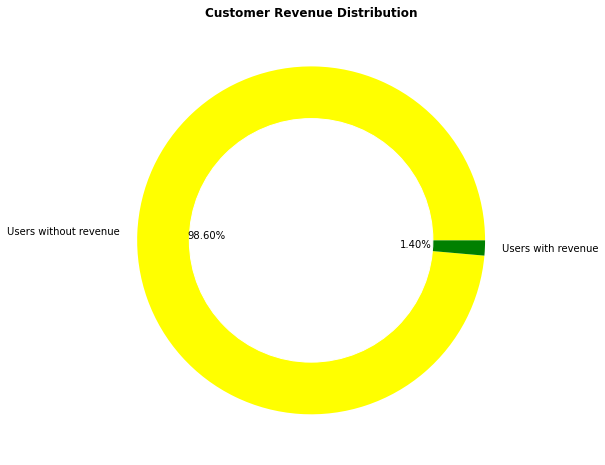

In [24]:
visitor_visits_revenue['user_revenue']=np.where(visitor_visits_revenue['sum_revenue']==0, 
                                             'Users without revenue', 'Users with revenue')
plt.figure(figsize=(10,8))
plt.pie(x=visitor_visits_revenue['user_revenue'].value_counts(), colors=['yellow','green'],
        labels=visitor_visits_revenue['user_revenue'].value_counts().index, autopct='%.2f%%')

plt.gca().add_artist(plt.Circle(xy=(0,0),radius=0.7,color='white'))
plt.title('Customer Revenue Distribution', fontdict={'fontweight':'bold'})
#del(visitor_visits_revenue)
plt.savefig("CustomerRevenueDist.png")
plt.show()


In [25]:
visitor_visits_revenue['user_revenue'].value_counts()

Users without revenue    704171
Users with revenue         9996
Name: user_revenue, dtype: int64

In [26]:
user_percent = len (visitor_visits_revenue[visitor_visits_revenue['sum_revenue']>0]) / len (visitor_visits_revenue['sum_revenue']) * 100
#len(df[(df['A']>0)
print(user_percent)

1.399672625590373


Percentage of users contributing to revenue is 1.4

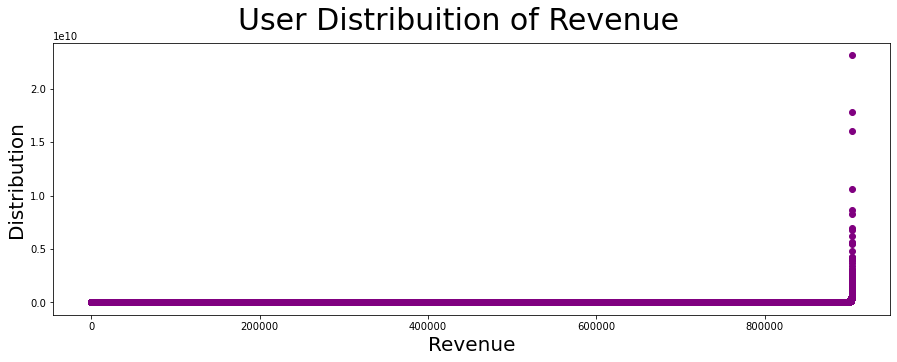

In [27]:
fig = plt.figure(figsize=(15,5))
plt.suptitle('User Distribuition of Revenue', fontsize=30)

# ax1 = fig.add_subplot(121)
# _ = sns.distplot(np.log(df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]), bins=40,color='#e56b6f', ax=ax1)
# _ = ax1.set_ylabel('Distribution', fontsize=20)
# _ = ax1.set_xlabel('Transaction Revenue Log', fontsize=20)


#ax2 = fig.add_subplot(122)
plt.scatter(range(ga_data_clean.shape[0]), np.sort(ga_data_clean['totals.transactionRevenue'].values), color='purple')
plt.ylabel('Distribution', fontsize=20)
plt.xlabel('Revenue', fontsize=20)
plt.savefig("RevenueDistribution.png")

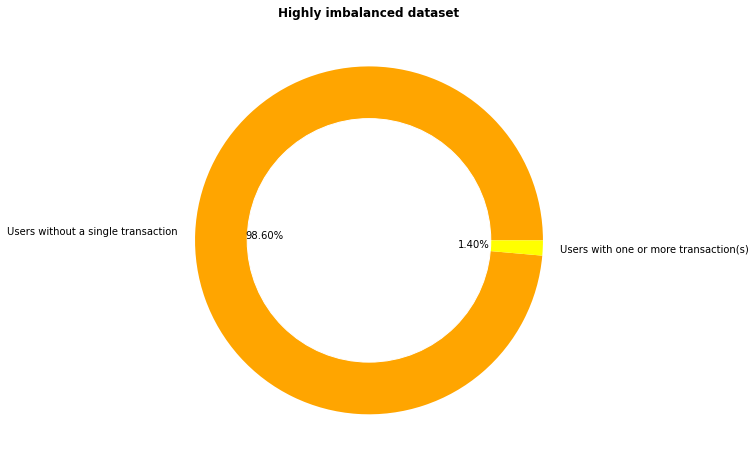

In [45]:
tmp_dist=pd.DataFrame(columns=['user_level_transactions'], data=ga_data_clean.groupby('fullVisitorId')['totals.transactionRevenue'].sum().values)

tmp_dist['user_level_transactions']=np.where(tmp_dist['user_level_transactions']==0, 
                                             'Users without a single transaction', 'Users with one or more transaction(s)')

plt.figure(figsize=(8,8))
plt.pie(x=tmp_dist['user_level_transactions'].value_counts(), colors=['orange','yellow'],
        labels=tmp_dist['user_level_transactions'].value_counts().index, autopct='%.2f%%')

plt.gcf().gca().add_artist(plt.Circle(xy=(0,0),radius=0.7,color='white'))
plt.title('Highly imbalanced dataset', fontdict={'fontweight':'bold'})
del(tmp_dist)
plt.show()

According to 80/20 it seems to be true that only a small percentage of customers produce most of the revenue

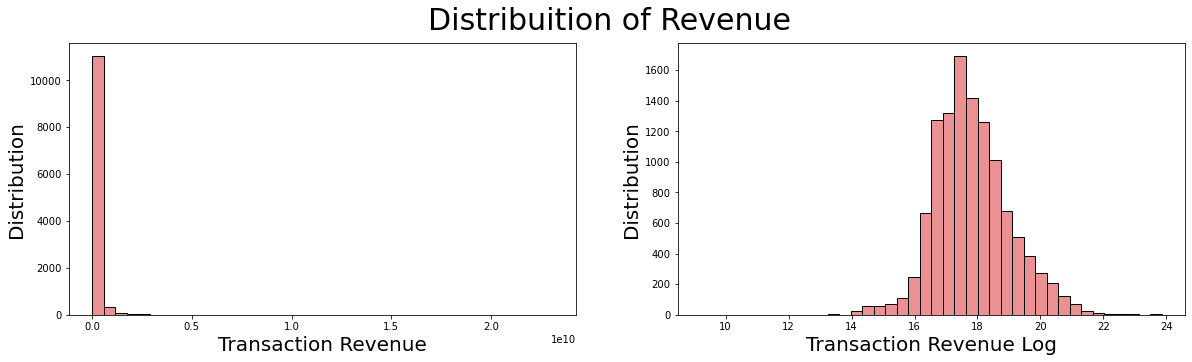

In [46]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Distribuition of Revenue', fontsize=30)

ax1 = fig.add_subplot(121)
sns.histplot(ga_data_clean[ga_data_clean['totals.transactionRevenue'] > 0]["totals.transactionRevenue"], bins=40,color='#e56b6f', ax=ax1)
ax1.set_ylabel('Distribution', fontsize=20)
ax1.set_xlabel('Transaction Revenue', fontsize=20)

ax2 = fig.add_subplot(122)
sns.histplot(np.log(ga_data_clean[ga_data_clean['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]), bins=40,color='#e56b6f', ax=ax2)
ax2.set_ylabel('Distribution', fontsize=20)
ax2.set_xlabel('Transaction Revenue Log', fontsize=20)
plt.savefig("NaturalRevenueDistribution.png")

In [47]:
channel_group_df = ga_data_clean.groupby('channelGrouping')['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'channelGrouping':'channel_group','count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})\
                         .sort_values(by=['mean_revenue'], ascending=False)
channel_group_df

,channel_group,no_of_users,total_revenue,mean_revenue
3,Display,6262,7.833746e+10,1.250997e+07
6,Referral,104838,6.514299e+11,6.213681e+06
2,Direct,143026,4.348406e+11,3.040290e+06
5,Paid Search,25326,4.355890e+10,1.719928e+06
4,Organic Search,381561,3.263805e+11,8.553823e+05
0,(Other),120,9.990000e+06,8.325000e+04
1,Affiliates,16403,5.973800e+08,3.641895e+04
7,Social,226117,4.916540e+09,2.174335e+04


In [48]:
browser_category_df = ga_data_clean.groupby('device.browser')['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'device.browser':'browser','count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})\
                         .sort_values(by=['mean_revenue'], ascending=False)
browser_category_df

,browser,no_of_users,total_revenue,mean_revenue
16,Firefox,37069,8.931632e+10,2.409461e+06
11,Chrome,620364,1.383105e+12,2.229506e+06
15,Edge,10205,6.482970e+09,6.352739e+05
20,Internet Explorer,19375,8.255550e+09,4.260929e+05
40,Safari,182245,5.239748e+10,2.875112e+05
3,Amazon Silk,561,2.999000e+07,5.345811e+04
36,Opera,5643,2.153500e+08,3.816233e+04
41,Safari (in-app),6850,1.537700e+08,2.244818e+04
6,Android Webview,7865,1.148500e+08,1.460267e+04
33,Nintendo Browser,140,0.000000e+00,0.000000e+00


In [49]:
OS_category_df = ga_data_clean.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'device.operatingSystem':'OS','count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})\
                         .sort_values(by=['mean_revenue'], ascending=False)
OS_category_df

,OS,no_of_users,total_revenue,mean_revenue
3,Chrome OS,26337,1.839378e+11,6.984005e+06
7,Macintosh,253938,8.563758e+11,3.372381e+06
6,Linux,35034,4.391040e+10,1.253365e+06
16,Windows,350072,3.973127e+11,1.134946e+06
1,Android,123892,3.634128e+10,2.933303e+05
19,iOS,107665,2.216690e+10,2.058877e+05
17,Windows Phone,1216,2.640000e+07,2.171053e+04
12,Nokia,2,0.000000e+00,0.000000e+00
18,Xbox,66,0.000000e+00,0.000000e+00
15,SunOS,1,0.000000e+00,0.000000e+00


In [50]:
device_category_df = ga_data_clean.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'device.deviceCategory':'device_category','count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})\
                         .sort_values(by=['mean_revenue'], ascending=False)
device_category_df

,device_category,no_of_users,total_revenue,mean_revenue
0,desktop,664479,1.480864e+12,2.228609e+06
2,tablet,30449,9.421340e+09,3.094138e+05
1,mobile,208725,4.978581e+10,2.385235e+05


In [68]:
traffic_medium_totals_df = ga_data_clean.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'trafficSource.medium':'traffic_source','count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})\
                         .sort_values(by=['mean_revenue'], ascending=False)
traffic_medium_totals_df


,traffic_source,no_of_users,total_revenue,mean_revenue
4,cpm,6262,7.833746e+10,1.250997e+07
0,(none),143026,4.348406e+11,3.040290e+06
6,referral,330955,6.563464e+11,1.983189e+06
3,cpc,25326,4.355890e+10,1.719928e+06
5,organic,381561,3.263805e+11,8.553823e+05
1,(not set),120,9.990000e+06,8.325000e+04
2,affiliate,16403,5.973800e+08,3.641895e+04


In [52]:
# date time conversion
# This function is to extract date features
# def date_process(df):
#     df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
#     df["weekday"] = df['date'].dt.weekday #extracting week day
#     df["day"] = df['date'].dt.day # extracting day
#     df["month"] = df['date'].dt.month # extracting day
#     df["year"] = df['date'].dt.year # extracting day
#     df['visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
#     return df

# ga_data_clean_date = date_process(ga_data_clean)

In [53]:
ga_data_clean["date"] = pd.to_datetime(ga_data_clean["date"], format="%Y%m%d")
ga_data_clean["weekday"] = ga_data_clean['date'].dt.weekday #extracting week day
ga_data_clean["day"] = ga_data_clean['date'].dt.day # extracting day
ga_data_clean["month"] = ga_data_clean['date'].dt.month # extracting day
ga_data_clean["year"] = ga_data_clean['date'].dt.year # extracting day
ga_data_clean['visit_hour'] = (ga_data_clean['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
ga_data_clean[["date","weekday","day","month","year","visit_hour"]]

,date,weekday,day,month,year,visit_hour
0,2016-09-02,4,2,9,2016,1
1,2016-09-02,4,2,9,2016,15
2,2016-09-02,4,2,9,2016,11
3,2016-09-02,4,2,9,2016,15
4,2016-09-02,4,2,9,2016,23
...,...,...,...,...,...,...
903648,2017-01-04,2,4,1,2017,5
903649,2017-01-04,2,4,1,2017,2
903650,2017-01-04,2,4,1,2017,21
903651,2017-01-04,2,4,1,2017,16


In [54]:
ga_data_clean.sort_values(by=['date'])

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,...,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,weekday,day,month,year,visit_hour
538448,Direct,2016-08-01,1492602573213666603,1,1470044332,Chrome,Macintosh,False,desktop,Asia,Eastern Asia,Japan,not available in demo dataset,...,1,1,1,0.0,(not set),(direct),(none),0,0,1,8,2016,19
538277,Direct,2016-08-01,7394165545362887055,3,1470044425,Chrome,Windows,False,desktop,Asia,Southeast Asia,Vietnam,Hanoi,...,1,1,0,0.0,(not set),(direct),(none),0,0,1,8,2016,19
538278,Referral,2016-08-01,6107229716178617930,1,1470094529,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,...,1,1,1,0.0,(not set),mall.googleplex.com,referral,0,0,1,8,2016,9
538279,Direct,2016-08-01,9459384188253198762,1,1470079413,Chrome,Windows,False,desktop,Americas,South America,Brazil,not available in demo dataset,...,1,1,1,0.0,(not set),(direct),(none),0,0,1,8,2016,5
538280,Direct,2016-08-01,4052177266351383392,1,1470111093,Safari,Macintosh,False,desktop,Asia,Southeast Asia,Thailand,not available in demo dataset,...,1,1,1,0.0,(not set),(direct),(none),0,0,1,8,2016,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64652,Direct,2017-08-01,0370352037468604196,2,1501581346,Chrome,Macintosh,False,desktop,Asia,Eastern Asia,China,not available in demo dataset,...,1,1,0,0.0,(not set),(direct),(none),0,1,1,8,2017,19
64651,Referral,2017-08-01,5321699176786856383,2,1501648138,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,...,1,1,0,0.0,(not set),gdeals.googleplex.com,referral,0,1,1,8,2017,14
64650,Affiliates,2017-08-01,6202772851799466410,1,1501602677,Chrome,Windows,False,desktop,Americas,South America,Bolivia,not available in demo dataset,...,1,1,1,0.0,Data Share Promo,Partners,affiliate,0,1,1,8,2017,1
64657,Referral,2017-08-01,7827431027330439153,1,1501624621,Chrome,Windows,False,desktop,Americas,Northern America,United States,California,...,1,1,1,0.0,(not set),mall.googleplex.com,referral,0,1,1,8,2017,7


In [55]:
revenue_by_date_df = ga_data_clean.groupby('date')['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})
revenue_by_date_df

,date,no_of_users,total_revenue,mean_revenue
0,2016-08-01,1711,6.116060e+09,3.574553e+06
1,2016-08-02,2140,1.361190e+09,6.360701e+05
2,2016-08-03,2890,0.000000e+00,0.000000e+00
3,2016-08-04,3161,1.182890e+09,3.742139e+05
4,2016-08-05,2702,5.594260e+09,2.070415e+06
...,...,...,...,...
361,2017-07-28,2433,4.709440e+09,1.935651e+06
362,2017-07-29,1597,1.045010e+09,6.543582e+05
363,2017-07-30,1799,2.254160e+09,1.253007e+06
364,2017-07-31,2620,1.141544e+10,4.357038e+06


In [56]:
revenue_by_weekday_df = ga_data_clean.groupby('weekday')['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})
revenue_by_weekday_df

,weekday,no_of_users,total_revenue,mean_revenue
0,0,140905,2.720503e+11,1.930735e+06
1,1,147279,3.074662e+11,2.087645e+06
2,2,146733,2.984884e+11,2.034228e+06
3,3,142399,2.691706e+11,1.890256e+06
4,4,128331,2.586567e+11,2.015543e+06
5,5,97646,5.839736e+10,5.980517e+05
6,6,100360,7.584172e+10,7.556967e+05


In [57]:
revenue_by_day_df = ga_data_clean.groupby(['year','month','day'])['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})
revenue_by_day_df

,year,month,day,no_of_users,total_revenue,mean_revenue
0,2016,8,1,1711,6.116060e+09,3.574553e+06
1,2016,8,2,2140,1.361190e+09,6.360701e+05
2,2016,8,3,2890,0.000000e+00,0.000000e+00
3,2016,8,4,3161,1.182890e+09,3.742139e+05
4,2016,8,5,2702,5.594260e+09,2.070415e+06
...,...,...,...,...,...,...
361,2017,7,28,2433,4.709440e+09,1.935651e+06
362,2017,7,29,1597,1.045010e+09,6.543582e+05
363,2017,7,30,1799,2.254160e+09,1.253007e+06
364,2017,7,31,2620,1.141544e+10,4.357038e+06


In [58]:
revenue_by_month_df = ga_data_clean.groupby(['year','month'])['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})
revenue_by_month_df

,year,month,no_of_users,total_revenue,mean_revenue
0,2016,8,74759,1.546666e+11,2.068869e+06
1,2016,9,71032,1.260312e+11,1.774288e+06
2,2016,10,97506,1.133291e+11,1.162278e+06
3,2016,11,113972,1.190139e+11,1.044238e+06
4,2016,12,79124,1.545579e+11,1.953363e+06
5,2017,1,64694,9.787779e+10,1.512935e+06
6,2017,2,62192,1.087565e+11,1.748722e+06
7,2017,3,69931,1.309643e+11,1.872764e+06
8,2017,4,67126,1.587888e+11,2.365533e+06
9,2017,5,65371,1.217115e+11,1.861857e+06


In [59]:
revenue_by_year_df = ga_data_clean.groupby('year')['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})
revenue_by_year_df

,year,no_of_users,total_revenue,mean_revenue
0,2016,436393,6.675987e+11,1.529811e+06
1,2017,467260,8.724726e+11,1.867210e+06


In [60]:
revenue_by_visit_hour_df = ga_data_clean.groupby('visit_hour')['totals.transactionRevenue'].agg(['count','sum','mean'])\
                         .reset_index()\
                         .rename(columns= {'count':'no_of_users','sum':'total_revenue','mean':'mean_revenue'})
revenue_by_visit_hour_df

,visit_hour,no_of_users,total_revenue,mean_revenue
0,0,42505,6.916910e+10,1.627317e+06
1,1,46293,1.028699e+11,2.222149e+06
2,2,48640,1.026216e+11,2.109818e+06
3,3,49848,1.264569e+11,2.536850e+06
4,4,50399,1.296545e+11,2.572561e+06
5,5,49447,1.492557e+11,3.018498e+06
6,6,48210,1.548387e+11,3.211755e+06
7,7,44914,1.075520e+11,2.394621e+06
8,8,41829,9.623681e+10,2.300720e+06
9,9,37885,7.768065e+10,2.050433e+06


Highly imbalanced dataset visualization - only 1.2% with revenue

## Prediction

In [ ]:
#    xgb = XGBRegressor(n_estimators=1000, max_depth=20, learning_rate=0.07, booster='gbtree', random_state=0, importance_type='total_gain',
#                        objective= 'reg:squarederror', gamma=1.45, alpha=0.0, subsample=0.67, colsample_bytree=0.054, colsample_bylevel= 0.50)
#     xgb.fit(train_x , train_y ,eval_set=[(validation_x, validation_y)], early_stopping_rounds=100, eval_metric='rmse', verbose=100)
#     predictions = xgb.predict(validation_x)
#     predictions[predictions<0]=0
#     print('{}{}.5) XGB LOSS = {}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y, predictions)**.5, '<'*26))

#     submission_preds_raw=xgb.predict(test_x)
#     submission_preds_raw[submission_preds_raw<0]=0
#     submission_xgb_preds +=  submission_preds_raw / len(kfold)
    
    
    
#     print('\n{} {}.6) TRAINING LGBRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
#     lgb_reg = lgb.LGBMRegressor(n_estimators=1100, objective='regression', max_depth=-1, learning_rate=0.08, min_child_samples=40, boosting='gbdt', 
#                                 feature_fraction=0.9, bagging_freq=10, bagging_fraction=0.8, bagging_seed=3, metric='rmse', lambda_l1=0, lambda_l2=1, verbosity=100)
#     lgb_reg.fit(train_x, train_y, eval_set= [(validation_x, validation_y)], eval_metric='rmse', verbose=100 ,early_stopping_rounds = 100)
#     predictions = lgb_reg.predict(validation_x.values, num_iteration=lgb_reg.best_iteration_)
#     predictions[predictions<0]=0
#     print('{}{}.7) LGB LOSS = {}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y.values, predictions)**.5, '<'*26))
#     submission_preds_raw=lgb_reg.predict(test_x.values, num_iteration=lgb_reg.best_iteration_)
#     submission_preds_raw[submission_preds_raw<0]=0

In [ ]:
# feature_importances=pd.DataFrame()
# feature_importances['features']=train_x.columns
# feature_importances['feature_importance']=lgb_reg.feature_importances_
# plt.figure(figsize=(10,12)) 
# plt.title('Feature Importance as per LGBRegressor', fontdict={'fontweight':'bold'})
# sns.barplot(x='feature_importance',y='features',data=feature_importances.sort_values('feature_importance',ascending=False), palette='twilight_r')
# plt.show()

In [ ]:

cat_columns = list(ga_data_clean.dtypes[ga_data_clean.dtypes == 'object'].reset_index()['index'])
# num_columns = num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits'] 

# for col in cat_columns:
#     df_train[col] = LabelEncoder().fit_transform(df_train[col])

# X = df_train[cat_columns + num_columns]
# y = df_train['totals.transactionRevenue']
cat_columns

In [ ]:
list(ga_data_clean.dtypes[ga_data_clean.dtypes != 'object'].reset_index()['index'])

In [ ]:
num_columns = ['visitNumber',
 'visitStartTime',
 'device.isMobile',
 'totals.visits',
 'weekday',
 'day',
 'month',
 'year',
 'visit_hour']

In [ ]:
ga_data_clean_train = ga_data_clean
ga_data_clean_train

In [ ]:
for col in cat_columns:
    ga_data_clean_train[col] = LabelEncoder().fit_transform(ga_data_clean_train[col].astype(str))


In [ ]:
ga_data_clean_train['logRevenue'] = np.log1p(ga_data_clean_train['totals.transactionRevenue'])
ga_data_clean_train.columns

In [ ]:
X = ga_data_clean_train[cat_columns + num_columns]
#y = ga_data_clean_train['totals.transactionRevenue']
y = ga_data_clean_train['logRevenue']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "min_child_samples" : 100,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.8,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 1042,
        "verbosity" : -1
    }

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test)


model = lgb.train(params, lgb_train, 1000, valid_sets=[lgb_val], early_stopping_rounds=300, verbose_eval=100)
    
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

## RMSE is 1.96647

In [ ]:
y_pred

In [ ]:
ga_data_clean_train[['totals.transactionRevenue','logRevenue']]

In [ ]:
plt.scatter(y_pred, y_pred - y_test)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max())
plt.savefig("ResidualPlot.png")
plt.show()

In [ ]:
y_zip = list(zip(y_test, y_pred))
y_zip_nonzero = [(x,y) for x,y in y_zip if x!= 0 ]
y_zip_nonzero

In [ ]:
y_pred_nz, y_test_nz = [], []
for x, y in y_zip_nonzero:
    y_pred_nz.append(x)
    y_test_nz.append(y)
#print(y_pred_nz)
print(y_test_nz)

In [ ]:
y_pred_nz = np.array(y_pred_nz)
y_test_nz = np.array(y_test_nz)

plt.scatter(y_pred_nz, y_test_nz - y_pred_nz, color = "green")
plt.hlines(y=0, xmin=y_pred_nz.min(), xmax=y_pred_nz.max(),color = "red")
plt.savefig("ResidualPlot.png")
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.plot(range(len(y_pred_nz)), y_pred_nz, color = "red")
plt.plot(range(len(y_test_nz)), y_test_nz, color = "green")
plt.savefig("CompareYtest&Yprediction.png")
plt.show()

In [ ]:
y_test

In [ ]:
model = lgb.LGBMRegressor( 
    metric='rmse',
    objective='regression',
    #is_unbalance=True, 
    #random_state=10, 
    n_estimators=50,
    num_leaves=30, 
    #max_depth=8,
    feature_fraction=0.5,  
    bagging_fraction=0.8, 
    bagging_freq=15, 
    #learning_rate=0.01,    
)

#         "objective" : "regression",
#         "metric" : "rmse", 
#         "num_leaves" : 30,
#         "min_child_samples" : 100,
#         "learning_rate" : 0.01,
#         "bagging_fraction" : 0.8,
#         "feature_fraction" : 0.5,
#         "bagging_frequency" : 5,
#         "bagging_seed" : 2018,
#         "verbosity" : -1
        

params_opt = {'n_estimators':range(200, 600, 80), 'num_leaves':range(20,60,10)}
gridSearchCV = GridSearchCV(estimator = model, 
    param_grid = params_opt, 
    scoring=None)
gridSearchCV.fit(X_train,y_train)
gridSearchCV.grid_scores_, gridSearchCV.best_params_, gridSearchCV.best_score_

In [ ]:
client.drop_database('GACustomer_data')


In [69]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)
client.drop_database('GA_Customer_DB')
# Define the 'GACustomer_data' database in Mongo
db = client.GA_Customer_DB

In [70]:
collection_continent = db['continent_totals']
collection_subcontinent = db['subcontinent_totals']
collection_country = db['country_totals']
collection_channel = db['channel_group_totals']
collection_browser = db['browser_category_totals']
collection_os = db['os_category_totals']
collection_device = db['device_category_totals']
collection_medium = db['traffic_medium_totals']
collection_source = db['traffic_source_totals']
collection_campaign = db['traffic_campaign_totals']
collection_weekday = db['weekday_totals']
collection_day = db['day_totals']
collection_month = db['month_totals']
collection_year = db['year_totals']
collection_visit_hour = db['visit_hour_totals']


In [71]:
continent_totals_dict = continent_totals_df.to_dict("records")
subcontinent_totals_dict = subcontinent_totals_df.to_dict("records")
country_totals_dict = country_totals_df.to_dict("records")
channel_group_totals_dict = channel_group_df.to_dict("records")
browser_category_totals_dict = browser_category_df.to_dict("records")
OS_category_totals_dict = OS_category_df.to_dict("records")
device_category_totals_dict = device_category_df.to_dict("records")
traffic_medium_totals_dict = traffic_medium_totals_df.to_dict("records")
traffic_source_totals_dict = traffic_source_totals_df.to_dict("records")
traffic_campaign_totals_dict = traffic_campaign_totals_df.to_dict("records")
revenue_by_weekday_totals_dict = revenue_by_weekday_df.to_dict("records")
revenue_by_day_totals_dict = revenue_by_day_df.to_dict("records")
revenue_by_month_totals_dict = revenue_by_month_df.to_dict("records")
revenue_by_year_totals_dict = revenue_by_year_df.to_dict("records")
revenue_by_visit_hour_totals_dict = revenue_by_visit_hour_df.to_dict("records")


In [72]:
collection_continent.insert_many(continent_totals_dict)
collection_subcontinent.insert_many(subcontinent_totals_dict)
collection_country.insert_many(country_totals_dict)
collection_channel.insert_many(channel_group_totals_dict)
collection_browser.insert_many(browser_category_totals_dict)
collection_os.insert_many(OS_category_totals_dict)
collection_device.insert_many(device_category_totals_dict)
collection_medium.insert_many(traffic_medium_totals_dict)
collection_source.insert_many(traffic_source_totals_dict)
collection_campaign.insert_many(traffic_campaign_totals_dict)
collection_weekday.insert_many(revenue_by_weekday_totals_dict)
collection_day.insert_many(revenue_by_day_totals_dict)
collection_month.insert_many(revenue_by_month_totals_dict)
collection_year.insert_many(revenue_by_year_totals_dict)
collection_visit_hour.insert_many(revenue_by_visit_hour_totals_dict)

In [73]:

collection_date = db['date_totals']
date_totals_dict = revenue_by_date_df.to_dict("records")
collection_date.insert_many(date_totals_dict)


In [74]:
date_totals_dict

[{'date': Timestamp('2016-08-01 00:00:00'),
  'no_of_users': 1711,
  'total_revenue': 6116060000.0,
  'mean_revenue': 3574552.893045003,
  '_id': ObjectId('616a3bf573aa5f550a1d548b')},
 {'date': Timestamp('2016-08-02 00:00:00'),
  'no_of_users': 2140,
  'total_revenue': 1361190000.0,
  'mean_revenue': 636070.0934579439,
  '_id': ObjectId('616a3bf573aa5f550a1d548c')},
 {'date': Timestamp('2016-08-03 00:00:00'),
  'no_of_users': 2890,
  'total_revenue': 0.0,
  'mean_revenue': 0.0,
  '_id': ObjectId('616a3bf573aa5f550a1d548d')},
 {'date': Timestamp('2016-08-04 00:00:00'),
  'no_of_users': 3161,
  'total_revenue': 1182890000.0,
  'mean_revenue': 374213.856374565,
  '_id': ObjectId('616a3bf573aa5f550a1d548e')},
 {'date': Timestamp('2016-08-05 00:00:00'),
  'no_of_users': 2702,
  'total_revenue': 5594260000.0,
  'mean_revenue': 2070414.5077720208,
  '_id': ObjectId('616a3bf573aa5f550a1d548f')},
 {'date': Timestamp('2016-08-06 00:00:00'),
  'no_of_users': 1663,
  'total_revenue': 1891040000.0

In [ ]:
xgb_params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.02,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456,
        'importance_type': 'total_gain'
    }

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

xgb = XGBRegressor(n_estimators=1000, max_depth=20, learning_rate=0.07, booster='gbtree', random_state=0, importance_type='total_gain',
                       objective= 'reg:squarederror', gamma=1.45, alpha=0.0, subsample=0.67, colsample_bytree=0.054, colsample_bylevel= 0.50)
xgb.fit(X_train , y_train ,eval_set=[(X_test, y_test)], early_stopping_rounds=100, eval_metric='rmse', verbose=100)
predictions = xgb.predict(X_test)
predictions[predictions<0]=0
print(mean_squared_error(y_train, predictions)**.5)
#print('{}{}.5) XGB LOSS = {}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y, predictions)**.5, '<'*26))

#     submission_preds_raw=xgb.predict(X_test)
#     submission_preds_raw[submission_preds_raw<0]=0
#     submission_xgb_preds +=  submission_preds_raw / len(kfold)
    

In [ ]:


from sklearn.preprocessing import MinMaxScaler

scaler1 = MinMaxScaler()


In [ ]:
def convert_category_todummies(df,field):
    #print('Processing ', field)
    dummy_df = pd.get_dummies(df[field])
    df = pd.concat([df,dummy_df],axis=1)
    df.drop(labels=[field],axis=1,inplace=True)
    return df
def convert_category_tolevel(df,field):
    df[field],index = pd.factorize(df[field])
    return df

In [ ]:
#Data cleaning
train_size = ga_data_clean.shape[0]

ga_data_clean['totals.pageviews']=ga_data_clean['totals.pageviews'].astype('int')
ga_data_clean['totals.hits']=merged_df['totals.pageviews'].astype('int')
merged_df = merged_df.drop(labels=['trafficSource.keyword'],axis=1)
print('Before: ', merged_df.shape)
columns = merged_df.columns
for fields in columns:
    if merged_df[fields].dtype == 'object' and fields not in ['fullVisitorId','method']:
        print('Unique values for ', fields, len(merged_df[fields].unique()), merged_df[fields].unique())
        if len(merged_df[fields].unique()) > 40:
            print('Level conversion')
            merged_df[fields] = convert_category_tolevel(merged_df,fields)
            merged_df[fields] = merged_df[fields].astype('int')
        else:
            print('One hot conversion')
            merged_df = convert_category_todummies(merged_df,fields)
            #merged_df = merged_df.drop(labels=[fields],axis=1)
print('After: ', merged_df.shape)

In [ ]:
ga_data_clean.dtypes

In [ ]:
train_x = ga_data_clean.groupby(by=['fullVisitorId']).mean()
train_x

In [ ]:
train_y = train_x['logRevenue']
train_x = train_x.drop(labels=['totals.transactionRevenue','logRevenue'],axis=1)
scaled_x = scaler1.fit_transform(train_x.values)
#train_y = np.log1p(train_y)
train_x = pd.DataFrame(scaled_x, columns=train_x.columns)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.15, random_state=1)

lgb_train_data = lgb.Dataset(X_train, label=y_train)
lgb_val_data = lgb.Dataset(X_val, label=y_val)

params = {
        "objective" : "regression",
        "metric" : "rmse",
        #"num_leaves" : 40,
        "max_depth" : 10,
        "boosting" : "gbdt",
        "learning_rate" : 0.0025,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "seed": 42}
model = lgb.train(params, lgb_train_data, 
                      num_boost_round=5000,
                      valid_sets=[lgb_train_data, lgb_val_data],
                      early_stopping_rounds=100,
                      verbose_eval=500)

In [ ]:
plt.style.use('ggplot')
lgb.plot_importance(model,max_num_features=15)

In [ ]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
print(f"LGBM: RMSE val: {np.sqrt(mean_squared_error(y_val, y_pred_val))}")

In [ ]:
plt.scatter(y_pred_val, y_pred_val - y_val,color="green")
plt.hlines(y=0, xmin=y_pred_val.min(), xmax=y_pred_val.max())
plt.savefig("Figures/ResidualPlot.png")
plt.show()